In [1]:
import scipy.special as sp
import math as ma
import numpy as np
import scipy.stats as st
import numba as nb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import bayessplicedmodels as bsm
from joblib import Parallel, delayed

# Pareto distribution

$X\sim\text{Pareto}(\alpha, \gamma)$ with pdf

$$
f(x) = \frac{\gamma^\alpha}{x^{\alpha+1}},\text{ }x>\gamma
$$

In [20]:
class loss_model:
    def __init__(self,name, parm_names):
        self.name = name
        self.parm_names = parm_names
        self.d= len(parm_names)
    
    def set_logp(self, X):
        if self.name == "Pareto":
            def logp(parms):
                α, γ = parms
                if np.all(parms > 0) and np.all(X >= γ) :
                    
                    return(len(X)*(np.log(α) + α * np.log(γ)) - (α + 1) * np.sum(np.log(X)))
                else:
                    return(-np.inf)
        self.logp = nb.jit(nopython = True)(logp)
    
    def set_logd(self, parms):
        if self.name == "Pareto":
            def logd(x):
                α, γ = parms[:,0], parms[:,1]
                res = np.zeros(len(α))
                s = np.logical_and(np.logical_and(α > 0, γ > 0), γ <= x)
                res[np.where(s)] = np.log(α[s]) + α[s] * np.log(γ[s]) - (α[s] + 1) * np.log(x) 
                res[np.where(np.invert(s))] = -np.inf
                return(res)
        self.logd = logd
    
    def set_cdf(self):
        if self.name == "Pareto":
            def cdf(parms, x):
                α, γ = parms
                return(1 - (γ / x)**α)
        self.cdf = nb.jit(nopython = True)(cdf)
    
    def set_pdf(self):
        if self.name == "Pareto":
            def pdf(parms, x):
                α, γ = parms
                return(α * γ**α / x**(α + 1))
        self.pdf = nb.jit(nopython = True)(pdf)
                
        
    def set_ppf(self):
        if self.name == "Pareto":
            def ppf(parms, y):
                α, γ = parms
                return( γ * ((1-y)**(-1 / α)))
        self.ppf = ppf
    
    def sample(self, parms, n):
        if self.name == "Pareto":
            α, γ = parms
            return( γ * st.pareto(α).rvs(n))

In [8]:
pareto_dist = loss_model("Pareto", ["α", "γ"])
print(pareto_dist.name, pareto_dist.parm_names, pareto_dist.d)
parms = np.array([1/2, 1/2])
α, γ = parms
x, y = 2, 0.5
pareto_dist.set_cdf(), pareto_dist.set_pdf(), pareto_dist.set_ppf()
pareto_dist.cdf(parms, x) - st.pareto(α).cdf(x / γ),\
pareto_dist.ppf(parms, y)-  γ * st.pareto(α).ppf(y),\
pareto_dist.pdf(parms, x)-  st.pareto(α).pdf(x / γ) / γ,\
pareto_dist.sample(parms, 10)

Pareto ['α', 'γ'] 2


(0.0,
 0.0,
 0.0,
 array([  0.65380282,   0.65185061,   0.65665883,   3.79686809,
          1.15687151,   1.32935782,   0.70111838,   0.79630985,
          8.65244222, 513.21614953]))

In [11]:
X = pareto_dist.sample(parms, 10)
pareto_dist.set_logp(X)
print(pareto_dist.logp(parms) - np.sum(np.log(st.pareto(α).pdf(X / γ) / γ)))

0.0


In [13]:
α_prior, γ_prior= bsm.prior_model('gamma','α', 1, 1), bsm.prior_model('gamma','σ', 1, 1)
prior_gamma_model = bsm.independent_priors([α_prior, γ_prior])
particle_cloud = prior_gamma_model.sample(20)
pareto_dist.set_logd(particle_cloud.values)
α_vec, γ_vec = particle_cloud.values[:,0], particle_cloud.values[:,1]
print(np.array([np.log(st.pareto(α_vec[i]).pdf(X[0] / γ_vec[i]) / γ_vec[i]) for i in range(len(γ_vec))] - 
               pareto_dist.logd(X[0])))

[            nan             nan  0.00000000e+00             nan
             nan             nan -1.66533454e-16             nan
             nan             nan             nan             nan
             nan -4.44089210e-16  1.94289029e-16  1.66533454e-16
             nan             nan             nan  0.00000000e+00]


C:\Users\pierr\AppData\Local\Temp/ipykernel_10676/3021872368.py:6: RuntimeWarning: divide by zero encountered in log
  print(np.array([np.log(st.pareto(α_vec[i]).pdf(X[0] / γ_vec[i]) / γ_vec[i]) for i in range(len(γ_vec))] -
C:\Users\pierr\AppData\Local\Temp/ipykernel_10676/3021872368.py:6: RuntimeWarning: invalid value encountered in subtract
  print(np.array([np.log(st.pareto(α_vec[i]).pdf(X[0] / γ_vec[i]) / γ_vec[i]) for i in range(len(γ_vec))] -


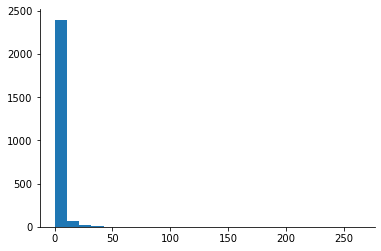

In [25]:
parms_true = np.array([2, 1])
f = loss_model("Pareto", ["α", "γ"])
# X = f.sample(parms_true, 100)
danish = pd.read_csv("Data/danish.csv").x
X = danish.values
plt.hist(X,bins=25)
sns.despine()

In [26]:
α_prior, γ_prior = bsm.prior_model('gamma','α', 1, 1), bsm.prior_model('fixed','γ', min(X), 1)
prior_single_model = bsm.independent_priors([α_prior, γ_prior])
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 2000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_single_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the gamma-fixed prior distribution
Generation: 1 ;temperature: 0.0015497207641601562 ;ESS: 1000 ;steps:5 ;particle moved: 99.3%
Generation: 2 ;temperature: 0.012437007160315261 ;ESS: 999 ;steps:5 ;particle moved: 99.2%
Generation: 3 ;temperature: 0.09185320636046929 ;ESS: 999 ;steps:5 ;particle moved: 99.5%
Generation: 4 ;temperature: 0.7123890670939562 ;ESS: 999 ;steps:3 ;particle moved: 100.0%
Generation: 5 ;temperature: 1.0 ;ESS: 1915 ;steps:3 ;particle moved: 100.0%
Wall time: 4.73 s


-5679.288240674828 11348.282949922615 11351.293745253335


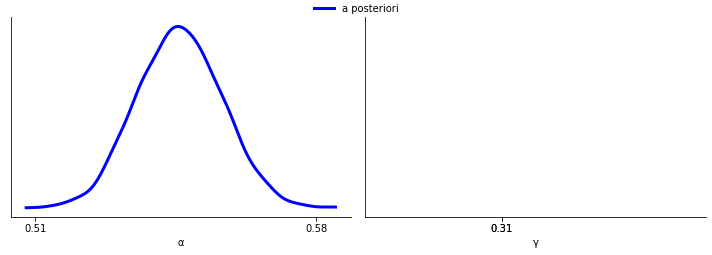

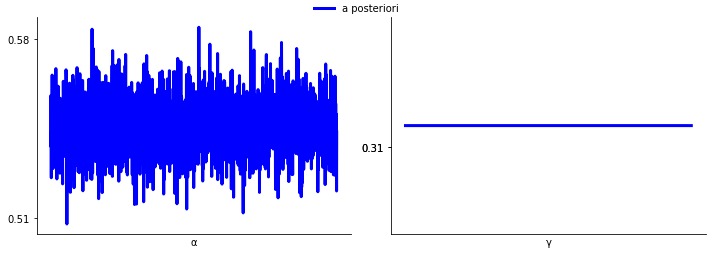

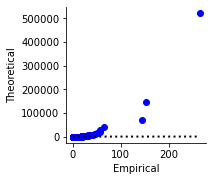

In [27]:
print(log_marg, DIC, WAIC)
bsm.posterior_plots(f, trace)
bsm.trace_plots(f, trace)
f.set_ppf()
bsm.qq_plot(X, f, trace.mean().values)